In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.externals import joblib
%load_ext autoreload
%autoreload 2
#пофитить кружки
#удалить "вылеты по касательной"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
raw_train = pd.read_csv('train.csv')
#raw_test = pd.read_csv('test.csv')


In [4]:
def group_by_event(data,n_wires= 4482):
    len_events = data.shape[0]/n_wires
    #ASSUME IT GOES IN A (event_id, wire_id)-lexicographic order
    return data.reshape((len_events,n_wires))

In [5]:
wires = pd.read_csv('wires.csv')
wires['_x']= wires.wire_rho*np.cos(wires.wire_phi)
wires['_y']= wires.wire_rho*np.sin(wires.wire_phi)
def draw_wire(data_row,cmap='Greys'):
    plt.figure(figsize=[12,10])
    
    pts = plt.scatter(wires._x,wires._y, c= data_row,cmap=cmap)
    
    plt.colorbar(orientation='vertical')
    plt.show()

In [6]:
evt_labels = group_by_event(raw_train.label)
evt_e = group_by_event(raw_train.energy_deposit)
evt_t = group_by_event(raw_train.relative_time)

evt id= 144


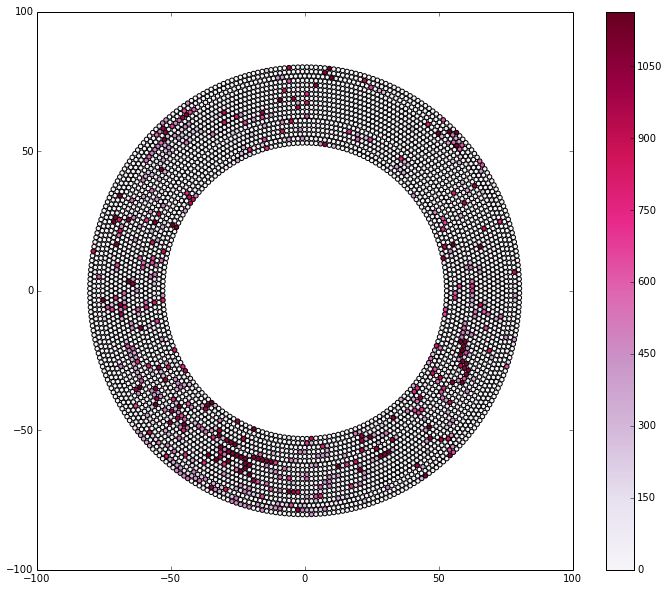

In [7]:
i = np.random.randint(1700)
print 'evt id=',i
draw_wire(evt_t[i,:],cmap='PuRd')
#draw_wire(evt_t[i,:]*(evt_labels[i,:]==1),cmap='Greys')


In [8]:
def to_features(raw_data,test=False):    
    
    data_sb = raw_data[raw_data.energy_deposit>0]
    features = {}
    
    features["timesq"] = np.array(data_sb.relative_time)**2
    features["enrgsqlog"] = np.log(np.array(data_sb.energy_deposit))**2
    features["wrho"] = wires.wire_rho[data_sb.wire_id]
    features["rhotime"] = wires.wire_rho[data_sb.wire_id]/(np.array(data_sb.relative_time)+1.)
    #features["wphi"] = wires.wire_phi[data_sb.wire_id]
    
    
    return (pd.DataFrame(features),data_sb.global_id ) if test else (pd.DataFrame(features),data_sb.label==1,data_sb.global_id)



In [9]:
subm = False
read = True
fname = 'dumps/lastrf-250-rhotime'
if subm:
    if not read:
        raw_train = pd.read_csv('train.csv')
        Xfeat,Y,ids=to_features(raw_train)
        del raw_train

        print Xfeat.shape
        from sklearn.ensemble import RandomForestClassifier
        rf = RandomForestClassifier(n_estimators=250,n_jobs=-1,verbose=2)
        rf.fit(Xfeat,Y)

        joblib.dump(rf,fname)
    else:
        rf = joblib.load(fname)
    raw_test = pd.read_csv('test.csv')
    
    n_parts = 100
    part_size = (len(raw_test)-1)/n_parts +100
    Y_parts = []
    ids_parts = []
    for i in range(n_parts):        
        raw_test_part = raw_test[i*part_size : (i+1)*part_size]
        data_test_part,ids_test_part = to_features(raw_test_part,test=True)
        Y_test_part = rf.predict_proba(data_test_part)[:,1]

        Y_parts.append(Y_test_part)
        ids_parts.append(ids_test_part)
    Y_test = np.concatenate(Y_parts)
    ids_test = np.concatenate(ids_parts)
    del raw_test
    ans = pd.DataFrame({"prediction":Y_test},index=ids_test)
    ans.to_csv("subm-250-rhotime.csv",index_label="global_id")

In [10]:
!ls

dp0.ipynb	    fit_circle_somehow.pyc  sample_submission.csv  test.csv
dumps		    main-Copy1.ipynb	    subm-250-rhotime.csv   train.csv
fit_circle_jacb.py  main.ipynb		    subm.csv		   wires.csv
fit_circle_l1.py    plotcircles.png	    submission.csv


In [11]:
n_events = len(raw_train)/4482
n_train = 500
n_test = n_events-n_train
in_train = np.arange(4482*n_train)
in_test = np.arange(4482*n_train,4482*n_events)

Xtr,Ytr,Idtr = to_features(raw_train.irow(in_train))
Xts,Yts,Idts = to_features(raw_train.irow(in_test))

In [13]:
read=True
fname='dumps/rf-100-rhotime-e500'
if not read:
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
    clf.fit(Xtr,Ytr)
    joblib.dump(clf,fname)
else:
    clf = joblib.load(fname)

In [14]:
from sklearn.metrics import roc_auc_score
Yts_pred = clf.predict_proba(Xts)[:,1]
roc_auc_score(Yts==1,Yts_pred)

0.98632276089521487

In [20]:
def get_neighbor_sel(wire_id,other_ids,wndsizes):
    wsel = wires.wire_id==wire_id
    wx = wires._x[wsel].values[0]
    wy = wires._y[wsel].values[0]
    
    other_sel = np.in1d(wires.wire_id, other_ids)
    others = wires[other_sel]
    
    distance = np.sqrt( (others._x - wx)**2 + (others._y - wy)**2)
    ans = []
    #print distance
    for wndsize in wndsizes:
        sel =distance < wndsize
        sel[others.wire_id == wire_id] = False #exclude self
        
        ans.append(sel)
    return ans
def to_neigh_features(raw_data,clf,test=False):
    data_sb = raw_data[raw_data.energy_deposit>0]
    
    
    data = to_features(raw_data,test)
    X = data[0]
    pred_proba = clf.predict_proba(X)[:,1]
    
    features = {}
    

    features["original_pred"] = pred_proba
    features["timesq"] = np.array(data_sb.relative_time)**2
    features["enrgsqlog"] = np.log(np.array(data_sb.energy_deposit))**2

    data_sb["original_pred"] = pred_proba
    
    window_sizes = [5]
    for d in window_sizes:
        data_sb["n_s"+str(d)]=0
        data_sb["n_t"+str(d)]=0
    
    
    events= np.unique(data_sb.event_id)
    data_by_evt = {evt:data_sb[data_sb.event_id==evt] for evt in events}
    for event in events:
        allwires = data_by_evt[event].wire_id
        lfeats = {}
        for d in window_sizes:
            lfeats["n_s"+str(d)] = np.zeros(len(allwires))
            lfeats["n_t"+str(d)] = np.zeros(len(allwires))
                
        for i in np.arange(len(allwires)):
            
            neighbors_sels = get_neighbor_sel(allwires.values[i],allwires,window_sizes)
            
            for sel,d in zip(neighbors_sels,window_sizes):
                lfeats["n_s"+str(d)][i] = np.sum(data_by_evt[event].original_pred)
                lfeats["n_t"+str(d)][i] = np.sum(sel)
        for d in window_sizes:
            data_by_evt[event]["n_s"+str(d)]=lfeats["n_s"+str(d)]
            data_by_evt[event]["n_t"+str(d)]=lfeats["n_t"+str(d)]
    data_sb = pd.concat(data_by_evt.values())
    
    for d in window_sizes:
        features["n_s"+str(d)]= data_sb["n_s"+str(d)]
        features["n_t"+str(d)]= data_sb["n_t"+str(d)]
    
    return (pd.DataFrame(features),data_sb.global_id ) if test else (pd.DataFrame(features),data_sb.label==1,data_sb.global_id)


In [ ]:
%%time
n_events = len(raw_train)/4482
n_train = 1200
n_test = n_events-n_train
in_test = np.arange(4482*n_train)
in_train = np.arange(4482*n_train,4482*n_events)
                                                                                                                                                                                            
Xts,Yts,Idts = to_neigh_features(raw_train.irow(in_test),clf)
Xtr,Ytr,Idtr = to_neigh_features(raw_train.irow(in_train),clf)
joblib.dump([Xtr,Ytr,Idtr],'dumps/transformed train')
joblib.dump([Xts,Yts,Idts],'dumps/transformed test')

In [ ]:
1

In [ ]:
Yts_pred = np.array(pd.DataFrame.from_csv('subm-250-rhotime.csv').prediction)
pred = np.zeros(n_test*4482)
pred[Idts-n_train*4482] = 2 - (Yts_pred>0.75)
pred = group_by_event(pred)
i = np.random.randint(len(pred))
draw_wire(pred[i,:]==1)

In [53]:
pred = np.zeros(n_test*4482)
pred[Idts-n_train*4482] = 2 - (Yts_pred>0.35)
pred = group_by_event(pred)

evt id= 633


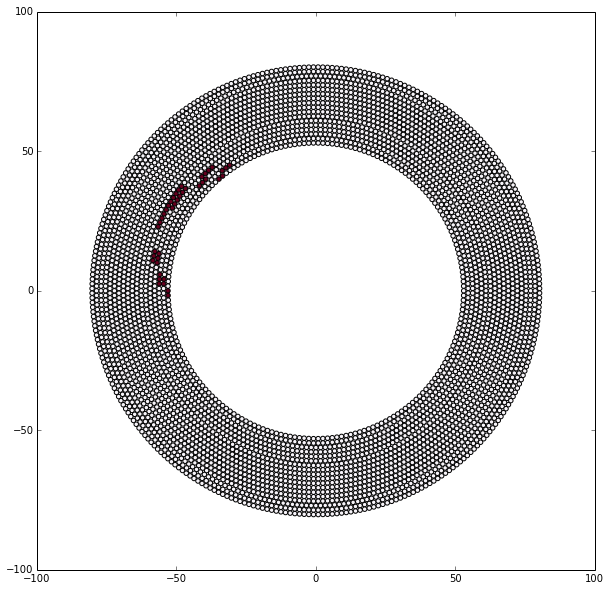

In [55]:
i = np.random.randint(len(pred))
print 'evt id=',i
draw_wire(evt_labels[n_train+i,:]==1,cmap='PuRd')
#draw_wire(pred[i,:]==1,cmap='PuRd')
#draw_wire(evt_labels[n_train+i,:]!=pred[i,:],cmap='PuRd')


In [64]:
from fit_circle_somehow import fit_circle as doit
def fit_circle(event_labels):
    Xs = wires._x
    Ys = wires._y
    (x,y,r) = doit(Xs[event_labels==1],Ys[event_labels==1])
    return x,y,r
x,y,r = fit_circle(pred[i,:])
x,y,r

(3.6052154585807097, -6.8302383128384898, 65.201749207493123)

In [88]:
from scipy import optimize
optimize.

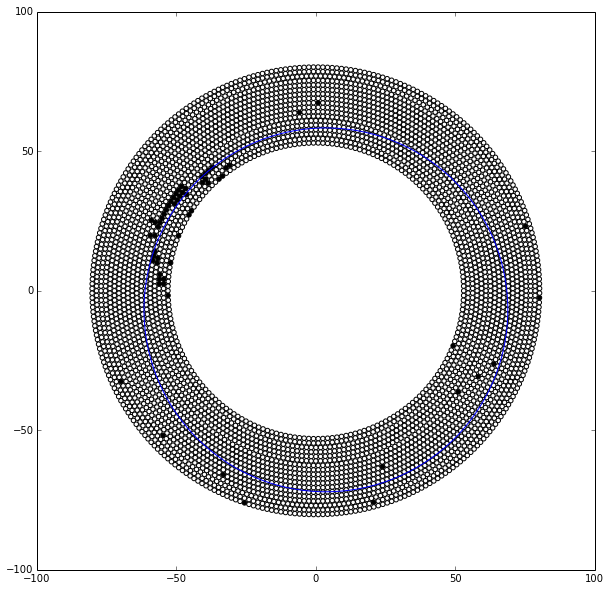

In [87]:
data_row = pred[i,:]==1
cmap = 'Greys'

fig = plt.figure(figsize=[10,10])
circle=plt.Circle((x,y),r,color='b',fill=False)

plt.scatter(wires._x,wires._y, c= data_row,cmap=cmap)
fig.gca().add_artist(circle)
plt.show()

In [334]:
from scipy import optimize
from numpy import *
x = None
y = None
l = None
scores=None
#weights = None

def f_2(c):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    xc,yc,r = c
    
    dr = absolute(sqrt(((x-xc)**2 + (y-yc)**2)) -r)
    #dr.sort()
    avg_s = np.average(dr[l==1])#,weights= weights[l==1])
    #avg_b = np.average(absolute(dr[l==2]),weights= weights[l==2])
    
    return  avg_s# - avg_b 

def doit(_x,_y,_l):
    wsize = 5
    global x,y,l,scores#,weights
    x=_x
    y=_y
    l=_l
    #weights = []
    scores = []
    for i in xrange(len(x)):
        dist_sq = ( (x-x[i])**2 + (y-y[i])**2)
        near_enough = dist_sq < wsize
        near_enough[i] = False #exclude self
        
        score = np.sum((1 - 2*(l[near_enough]==2))) #/dist_sq[near_enough]
        scores.append(score)
        
        #weights.append(1)#1./mean(dist_sq))
    
    #weights = np.array(weights)
    scores = np.array(scores)
    good = scores>1
    x = x[good]
    y = y[good]
    l = l[good]
    scores = scores[good]
    #weights = weights[good]
    

    center_estimate = mean(x), mean(y),30.
    print center_estimate
    
    center_2= optimize.fmin(f_2, center_estimate)#,maxiter=100000,maxfun=100000)
    
    xc_2, yc_2,R_2 = center_2
    return xc_2,yc_2,R_2
def fit_circle(event_labels):
    Xs = np.array(wires._x)
    Ys = np.array(wires._y)
    (xf,yf,rf) = doit(Xs[event_labels!=0],Ys[event_labels!=0],event_labels[event_labels!=0])
    return xf,yf,rf


(-11.131880789322354, -51.650296180023219, 30.0)


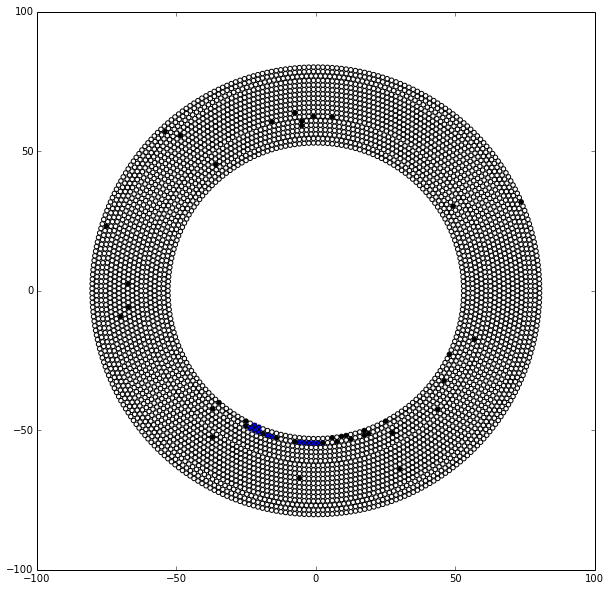

In [337]:
i = random.randint(len(pred)-1)
xc,yc,rc = fit_circle(pred[i,:])
xc,yc,rc

crcl = plt.Circle([xc,yc],radius=rc,color='b',fill=False)
fig = plt.figure(figsize=[10,10]) 
plt.gcf().gca().add_artist(crcl)
plt.scatter(wires._x,wires._y, c= pred[i,:]==1,cmap=cmap)
plt.scatter(x[l==1],y[l==1],marker='x')

plt.show()

In [ ]:
i = random.randint(len(pred)-1)
xc,yc,rc = fit_circle(pred[i,:])
xc,yc,rc

crcl = plt.Circle([xc,yc],radius=rc,color='b',fill=False)
fig = plt.figure(figsize=[10,10]) 
plt.gcf().gca().add_artist(crcl)
plt.scatter(wires._x,wires._y, c= pred[i,:]==1,cmap=cmap)
plt.scatter(x[l==1],y[l==1],marker='x')

plt.show()

In [330]:
pred = np.zeros(n_test*4482)
pred[Idts-n_train*4482] = 2 - (Yts_pred>0.35)
pred = group_by_event(pred)

630136320.64439607